# Objective
This study is a comparative exploration of dense neural networks and convolutional neural networks (CNNs) for image classification, with a two-fold goal: develop a neural network model for highly-accurate and generalizable  classification and gain an in-depth understanding of how various factors affect fitting and ultimate test set performance with networks of differing topologies and hyperparameter settings. 

These experiments will help determine different deep learning models' potential utility in classification problems for computer vision on the Fashion MNIST dataset of Zalando's article images and for future analogous image recognition problems, for example facial recognition.

# Experimental overview
Five experiments are run to evaluate and compare various network topologies and hyperparameter settings, assessing their potential impact on model performance (loss and accuracy) and process time. The following four are included here:

* **EXPERIMENT 1: DNN with 2 layers (no drop out)**

* **EXPERIMENT 2: DNN with 3 layers (no drop out)**

* **EXPERIMENT 3: CNN with 2 convolution/max pooling layers (no drop out)**

* **EXPERIMENT 4: CNN with 3 convolution/max pooling layers (no drop out)**

* EXPERIMENT 5: Re-run all experiments 1-4 with 20 percent dropout regularization to gauge its effectiveness in addressing issues with variance

In each experiment, certain parameters are held constant for comparison:
* Batch size = 100
* Epochs = 20
* Loss function = sparse categorical cross-entropy
* Optimizer = Adam

## Setup and dependencies

In [0]:
# Import dependencies
import numpy as np
import pandas as pd
import os
from collections import Counter
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Check Keras version
keras.__version__

'2.3.0-tf'

In [0]:
# Check tensorflow version
tf.__version__

'2.2.0-rc4'

In [0]:
# Set seed for consistency of results
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Saving in Colab
os.getcwd()
%cd /content/gdrive/My\ Drive/MSDS458/weekfive
!pwd
!ls
print('Working Directory')
print(os.getcwd())
work_dir = "content/gdrive/My Drive/MSDS458/weekfive"
# chp_id = "ann"

/content/gdrive/My Drive/MSDS458/weekfive
/content/gdrive/My Drive/MSDS458/weekfive
figures  model.png  results
Working Directory
/content/gdrive/My Drive/MSDS458/weekfive


## Import dataset: Fashion MNIST
Zalando is Europe's leading online fashion platform for women, men and children. `Fashion-MNIST` is a dataset of their product images. Just like the `MNIST` dataset, the `Fashion-MNIST` also consists of 70,000 grayscale images of 28x28 pixels divided into 60,000 training images and 10,000 test images. 

Each image is labeled with with an integer from 0 to 9 representing 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', respectively. 

`Fashion-MNIST` is intended to serve as a direct drop-in replacement for the original `MNIST` dataset for benchmarking machine learning algorithms since the the original `MNIST` was found to be too easy for the current machine learning models. In particular, Fashion-Mist shares the same image size and structure of training and testing splits as `MNIST`. Also like `MNIST` it comes prepackaged in `tf.Keras`. We use:

```python
fashion_mnist.load_data()
```
which provides datasets (and the corresponding labels) as Numpy arrays. See the `Fashion-MNIST` GitHub page for a lot more information about the data sets and benchmarks for 129 classifiers trained on the data:

https://github.com/zalandoresearch/fashion-mnist

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [0]:
# The training labels consist of integers from 0 to 9. Note that samples are balanced across labels/classes.
Counter(train_labels).most_common()

[(9, 6000),
 (0, 6000),
 (3, 6000),
 (2, 6000),
 (7, 6000),
 (5, 6000),
 (1, 6000),
 (6, 6000),
 (4, 6000),
 (8, 6000)]

In [0]:
# https://github.com/zalandoresearch/fashion-mnist
# https://www.tensorflow.org/tutorials/keras/classification

# Labels correspond to classes of clothing:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

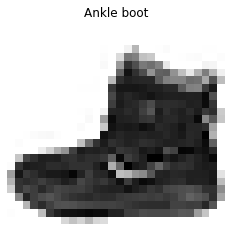

In [0]:
# https://matplotlib.org/tutorials/colors/colormaps.html?highlight=colormap
# Check a training image example - an ankle boot
plt.imshow(train_images[0], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

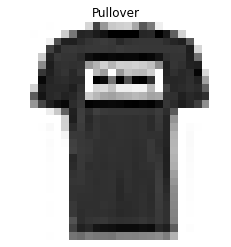

In [0]:
# Check another image - a pullover
plt.imshow(train_images[1], cmap="binary") 
plt.axis('off')
plt.title(class_names[test_labels[1]], fontsize=12)
plt.show()

## Data pre-processing
Before training, data is reshaped into the shape that the network expects and scaled so that all values are in the \[0, 1] interval.

Training images are stored in an array of shape (60000, 28, 28) of type uint8 with values in the [0, 255] interval. 

Training data is then transformed a float32 array of shape (60000, 28 * 28) with values between 0 and 1.

In [0]:
# We transform it into a float32 array of shape (60000, 28 * 28) with values between 0 and 1. 

#train_images = train_images.reshape((60000, 28 * 28))  # Decided instead to use a Flatten layer in the model
train_images = train_images.astype('float32') / 255

#test_images = test_images.reshape((10000, 28 * 28))  # Decided instead to use a Flatten layer in the model
test_images = test_images.astype('float32') / 255

## Train/test/validation split
70,000 images are divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. Since we will be using `sparse_categorical_crossentropy` as the loss function we **do not** need to use `to_categorical` to convert the class vector of labels to binary matrix representation.

In [0]:
# Create validation data
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Create a callback to get training times and test evaluation times

In [0]:
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

# EXPERIMENT  1:

The baseline `DNN` model will consist of 784 input nodes, a hidden layer with 5 nodes and 10 output nodes (corresponding to the 10 fashion categories).

## Build the network

Here the network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 

The first `Dense` layer, the hidden layer, consists of 5 nodes.

The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of 10 classes.

In [0]:
model_1 = models.Sequential()
model_1.add(layers.Flatten(input_shape=[28, 28]))
model_1.add(layers.Dense(5, activation='relu'))
model_1.add(layers.Dense(10, activation='softmax')) 

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 3925      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                60        
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


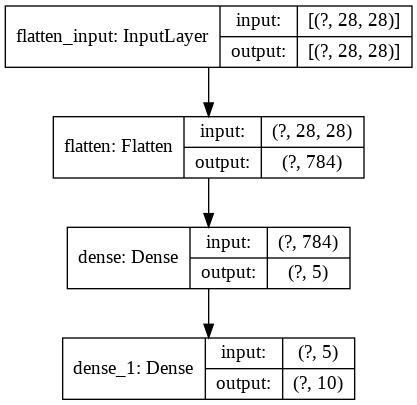

In [0]:
keras.utils.plot_model(model_1, show_shapes=True)

## Compile the model

To make our network ready for training, the compilation step consists of the following:

* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be able to steer itself in the right direction.
* Metrics to monitor during training and testing. We will use accuracy in this case (the fraction of the images that were correctly classified).

In [0]:
model_1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [0]:
train_rt = TrainRuntimeCallback()
history = model_1.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size=100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_1.h5'
model_path = os.path.join(save_dir, model_name)
model_1.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 3ms/step - loss: 1.1311 - accuracy: 0.5810 - val_loss: 0.7227 - val_accuracy: 0.7440
Epoch 2/20
550/550 [==============================] - 2s 3ms/step - loss: 0.6690 - accuracy: 0.7633 - val_loss: 0.6057 - val_accuracy: 0.7990
Epoch 3/20
550/550 [==============================] - 2s 3ms/step - loss: 0.5851 - accuracy: 0.7973 - val_loss: 0.5513 - val_accuracy: 0.8124
Epoch 4/20
550/550 [==============================] - 1s 3ms/step - loss: 0.5474 - accuracy: 0.8099 - val_loss: 0.5204 - val_accuracy: 0.8188
Epoch 5/20
550/550 [==============================] - 2s 3ms/step - loss: 0.5246 - accuracy: 0.8162 - val_loss: 0.5048 - val_accuracy: 0.8304
Epoch 6/20
550/550 [==============================] - 2s 3ms/step - loss: 0.5092 - accuracy: 0.8234 - val_loss: 0.4919 - val_accuracy: 0.8338
Epoch 7/20
550/550 [==============================] - 2s 3ms/step - loss: 0.4987 - accuracy: 0.8256 - val_loss: 0.4840 - val_accuracy: 0.8376
Epoch 

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

33.456518

In [0]:
model_1.layers[1].weights

[<tf.Variable 'dense/kernel:0' shape=(784, 5) dtype=float32, numpy=
 array([[-0.08495639, -0.02450575,  0.5867727 , -0.18403265, -0.3040383 ],
        [-0.13381945,  0.01560665,  0.09165871, -0.07803693,  0.00608772],
        [ 0.39040846, -0.40665108, -0.47576347, -0.48878852, -0.10543976],
        ...,
        [ 0.47443506,  0.41354418,  0.10599013, -0.03145849,  0.23590441],
        [ 0.00998975,  0.60049963, -0.11730584, -0.19239643,  0.39222458],
        [ 0.07808989,  0.43139702,  0.21162069, -0.4896956 ,  0.10832095]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(5,) dtype=float32, numpy=
 array([ 1.0045774 ,  0.89614654,  0.6753078 ,  0.9230628 , -0.32683727],
       dtype=float32)>]

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_1.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 3ms/step - loss: 0.5005 - accuracy: 0.8283


In [0]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.95997

## Create a DataFrame for the training and test statistics

We will create a pandas DataFrame to hold the training/test times and their accuracy and loss values of each of the four models (and their variations) that we will consider in these experiment. Statistics from all subsequent models are added to the DataFrame.

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.453059,0.842582,0.457761,0.8472
16,0.450715,0.842636,0.458308,0.8434
17,0.449201,0.845018,0.455511,0.8446
18,0.446930,0.844691,0.452145,0.8442
19,0.445179,0.845818,0.446092,0.8482


In [0]:
# Create a results DataFrame using the last row of history_df
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layers)') # went the model name to appear first
results_df['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (2 layers),0.445179,0.845818,0.446092,0.8482,33.456518,0.95997


## Plot the performance 

**Figure 1: Learning curves for Model 1**

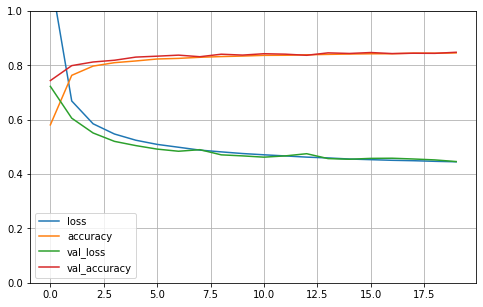

In [0]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_1", tight_layout=False)
plt.show()

# EXPERIMENT  2:

This time our `DNN` model will consist of 784 input nodes, a hidden layer with `10 nodes`, another hidden layer with `5 nodes` and 10 output nodes (corresponding to the 10 fashion categories).

In [0]:
# Instead of adding the layers one by one, we can pass a list of layers when creating the Sequential mode.
model_2 = models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                60        
Total params: 7,965
Trainable params: 7,965
Non-trainable params: 0
_________________________________________________________________


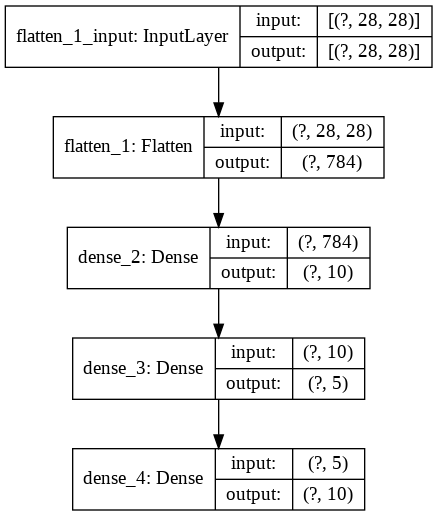

In [0]:
keras.utils.plot_model(model_2, show_shapes=True)

## Compile the model

In [0]:
model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [0]:
train_rt = TrainRuntimeCallback()
history = model_2.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_2.h5'
model_path = os.path.join(save_dir, model_name)
model_2.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 3ms/step - loss: 1.0676 - accuracy: 0.6358 - val_loss: 0.6508 - val_accuracy: 0.7860
Epoch 2/20
550/550 [==============================] - 2s 3ms/step - loss: 0.5892 - accuracy: 0.8031 - val_loss: 0.5339 - val_accuracy: 0.8238
Epoch 3/20
550/550 [==============================] - 2s 3ms/step - loss: 0.5278 - accuracy: 0.8223 - val_loss: 0.5148 - val_accuracy: 0.8268
Epoch 4/20
550/550 [==============================] - 2s 3ms/step - loss: 0.5000 - accuracy: 0.8298 - val_loss: 0.4879 - val_accuracy: 0.8360
Epoch 5/20
550/550 [==============================] - 2s 3ms/step - loss: 0.4850 - accuracy: 0.8338 - val_loss: 0.4836 - val_accuracy: 0.8414
Epoch 6/20
550/550 [==============================] - 2s 3ms/step - loss: 0.4720 - accuracy: 0.8400 - val_loss: 0.4679 - val_accuracy: 0.8440
Epoch 7/20
550/550 [==============================] - 2s 3ms/step - loss: 0.4609 - accuracy: 0.8425 - val_loss: 0.4647 - val_accuracy: 0.8464
Epoch 

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

33.351694

In [0]:
model_2.layers[1].weights

[<tf.Variable 'dense_2/kernel:0' shape=(784, 10) dtype=float32, numpy=
 array([[ 0.49256217,  0.04878269, -0.47940636, ...,  0.2854625 ,
         -0.388285  , -0.02152865],
        [ 0.5183466 ,  0.25312173,  0.5069261 , ..., -0.21221091,
         -0.6505492 ,  0.34231713],
        [ 0.18238339, -0.15022112, -0.21308587, ...,  0.27302256,
         -0.6952757 , -0.19941929],
        ...,
        [-0.23606902, -0.13785194,  0.06954483, ..., -0.06773199,
          0.23245032,  0.4226936 ],
        [ 0.42236978, -0.7625251 , -0.14763357, ...,  0.2259653 ,
          0.2537988 ,  0.16036206],
        [ 0.21001178, -0.11549328, -0.16125637, ...,  0.28574917,
         -0.25067624, -0.07645912]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.33735588,  0.40660846, -0.00816519,  0.27010486, -0.31941098,
         0.47647417, -0.01031993, -0.1382692 , -0.25403655,  0.60228413],
       dtype=float32)>]

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_2.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 3ms/step - loss: 0.4548 - accuracy: 0.8411


In [0]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

0.907039

## Add the statistics to the results DataFrame

We add the performance statistics for the new model to our DataFrame using history.

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.408491,0.858836,0.426024,0.8558
16,0.403272,0.860273,0.427999,0.8570
17,0.401089,0.860364,0.422517,0.8564
18,0.396556,0.862800,0.418954,0.8612
19,0.393804,0.862691,0.418285,0.8578


In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
results_df2 = history_df.iloc[-1:].copy()
results_df2.insert(0,'model','DNN (3 layers)') # went the model name to appear first
results_df2['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df2['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df2

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,DNN (3 layers),0.393804,0.862691,0.418285,0.8578,33.351694,0.907039


In [0]:
# # Add the new data to results_df
# results_df=results_df.append(results_df2,ignore_index=True)
# results_df

## Save our DataFrame to disk

The code below can be used to pickle the DataFrame so that we keep adding to it in Experiment 3.

In [0]:
# results_df.to_pickle("results.pkl") # save the DataFrame to use in Part 2

## Plot the performance 

**Figure 2: Learning curves for Model 2**

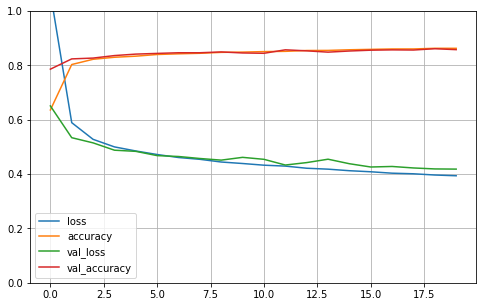

In [0]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_2", tight_layout=False)
plt.show()

# EXPERIMENT 3

We create a `CNN` with 2 convolution/max pooling layers (**no drop out**) to work with our Fashion MNIST dataset. All layers will use the ReLU activation function.

This experiment evaluates the following for impact on model performance and process time:
* Image augmentation
* L2 regularization

"Best" configurations from this experiment will be applied to Experiment 4, with 4 convolution/max pooling layers.

## Data preparation
Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the [0, 1] interval.

Currently, our training images are stored in an array of shape (60000, 28, 28). Each image is represented by a 28x28 array of uint8 values in the range [0, 255]. 

We transform it into a float32 array of shape (60000, 28, 28, 1) with values between 0 and 1.

In [0]:
# Data re-import and preparation
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [0]:
# Reshape images and scale
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

In [0]:
# Validation images
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

## Model 3a: baseline model (no image augmentation or L2 regularization)
We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes.

In [0]:
model_3a = models.Sequential()
model_3a.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_3a.add(layers.MaxPooling2D((2, 2)))
model_3a.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3a.add(layers.MaxPooling2D((2, 2)))
model_3a.add(layers.Flatten())
model_3a.add(layers.Dense(128, activation='relu'))
model_3a.add(layers.Dense(10, activation='softmax'))

In [0]:
model_3a.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

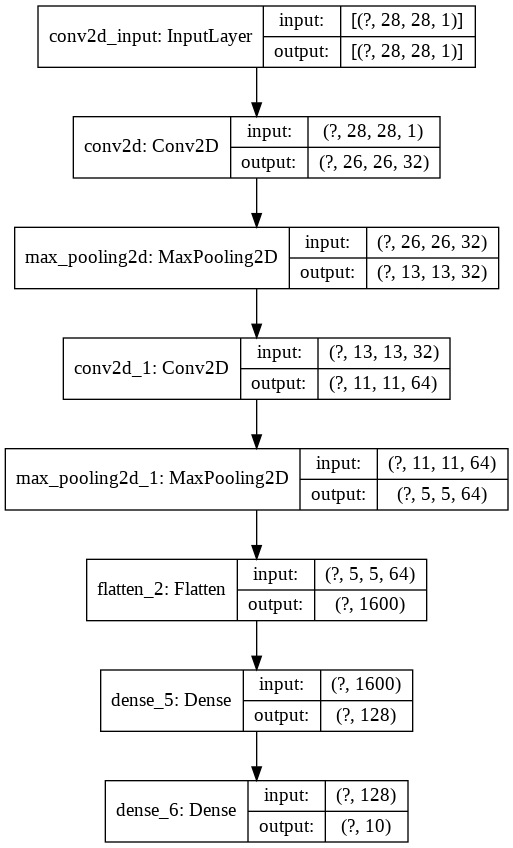

In [0]:
keras.utils.plot_model(model_3a, show_shapes=True)

## Compile the model

In [0]:
model_3a.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [0]:
train_rt = TrainRuntimeCallback()
history = model_3a.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_3a.h5'
model_path = os.path.join(save_dir, model_name)
model_3a.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 0.5390 - accuracy: 0.8061 - val_loss: 0.3848 - val_accuracy: 0.8630
Epoch 2/20
550/550 [==============================] - 2s 4ms/step - loss: 0.3553 - accuracy: 0.8726 - val_loss: 0.3537 - val_accuracy: 0.8752
Epoch 3/20
550/550 [==============================] - 2s 4ms/step - loss: 0.3107 - accuracy: 0.8873 - val_loss: 0.2964 - val_accuracy: 0.8966
Epoch 4/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2791 - accuracy: 0.8979 - val_loss: 0.2724 - val_accuracy: 0.9030
Epoch 5/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2564 - accuracy: 0.9057 - val_loss: 0.2722 - val_accuracy: 0.9036
Epoch 6/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2333 - accuracy: 0.9145 - val_loss: 0.2474 - val_accuracy: 0.9136
Epoch 7/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2170 - accuracy: 0.9202 - val_loss: 0.2475 - val_accuracy: 0.9100
Epoch 

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

46.694116

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_3a.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 3ms/step - loss: 0.3642 - accuracy: 0.9067


In [0]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

1.092569

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.095310,0.964909,0.275010,0.9124
16,0.085218,0.968691,0.274441,0.9144
17,0.078263,0.971491,0.297201,0.9112
18,0.068062,0.974782,0.317024,0.9140
19,0.062694,0.977255,0.342600,0.9102


In [0]:
# Pull statistics 
results_df3a = history_df.iloc[-1:].copy()
results_df3a.insert(0,'model','CNN (2 layers)') # want the model name to appear first
results_df3a['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3a['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3a

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers),0.062694,0.977255,0.3426,0.9102,46.694116,1.092569


In [0]:
# # Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = prev_results_df.append(results_df,ignore_index=True)
# results_df

## Plot the performance 

**Figure 3: Learning curves for Model 3a**

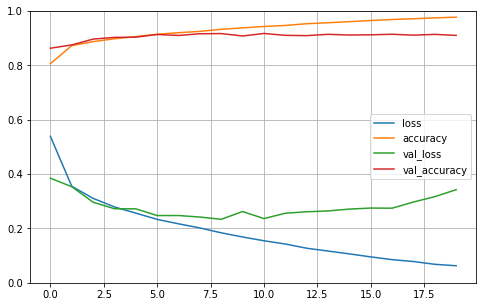

In [0]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3a", tight_layout=False)
plt.show()

## Model 3b: baseline model with L2 regularization
We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes. L2 regularization is employed to evaluate whether it addresses overfitting.

In [0]:
model_3b = models.Sequential()
model_3b.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), 
                           input_shape=(28, 28, 1)))
model_3b.add(layers.MaxPooling2D((2, 2)))
model_3b.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3b.add(layers.MaxPooling2D((2, 2)))
model_3b.add(layers.Flatten())
model_3b.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3b.add(layers.Dense(10, activation='softmax'))

In [0]:
model_3b.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               204928    
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

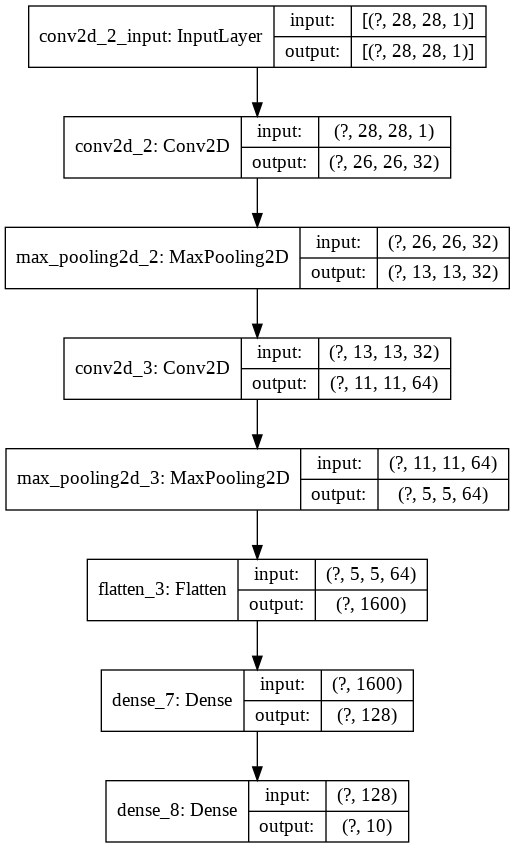

In [0]:
keras.utils.plot_model(model_3b, show_shapes=True)

## Compile the model

In [0]:
model_3b.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [0]:
train_rt = TrainRuntimeCallback()
history = model_3b.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_3b.h5'
model_path = os.path.join(save_dir, model_name)
model_3b.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 1.1126 - accuracy: 0.7657 - val_loss: 0.7304 - val_accuracy: 0.8098
Epoch 2/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7035 - accuracy: 0.8146 - val_loss: 0.6615 - val_accuracy: 0.8350
Epoch 3/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6633 - accuracy: 0.8246 - val_loss: 0.6494 - val_accuracy: 0.8228
Epoch 4/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6440 - accuracy: 0.8302 - val_loss: 0.6099 - val_accuracy: 0.8440
Epoch 5/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6202 - accuracy: 0.8378 - val_loss: 0.5768 - val_accuracy: 0.8582
Epoch 6/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6094 - accuracy: 0.8387 - val_loss: 0.6172 - val_accuracy: 0.8382
Epoch 7/20
550/550 [==============================] - 2s 4ms/step - loss: 0.5990 - accuracy: 0.8401 - val_loss: 0.5750 - val_accuracy: 0.8512
Epoch 

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

43.898222

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_3b.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 3ms/step - loss: 0.5241 - accuracy: 0.8557


In [0]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

1.081623

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.537581,0.852782,0.532768,0.8570
16,0.535714,0.854091,0.517798,0.8644
17,0.528900,0.855455,0.522401,0.8616
18,0.522790,0.857945,0.503567,0.8684
19,0.520660,0.857909,0.493949,0.8732


In [0]:
# Pull statistics 
# Pull statistics 
results_df3b = history_df.iloc[-1:].copy()
results_df3b.insert(0,'model','CNN (2 layers L2)') # want the model name to appear first
results_df3b['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3b['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3b

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers L2),0.52066,0.857909,0.493949,0.8732,43.898222,1.081623


## Plot the performance 

**Figure 4: Learning curves for Model 3b**

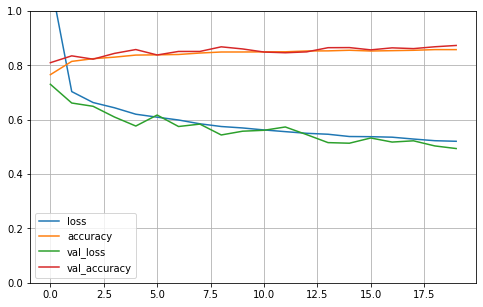

In [0]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3b", tight_layout=False)
plt.show()

## Model 3c: baseline model with image augmentation
We build a `CNN` containing 2 convolutional/max pooling layers. The last layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current clothing image belongs to one of our 10 classes. Image augmentation (shifting, flipping, shearing, and zooming) is employed to generate data and potentially mitigate overfitting. 

In [0]:
model_3c = models.Sequential()
model_3c.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_3c.add(layers.MaxPooling2D((2, 2)))
model_3c.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3c.add(layers.MaxPooling2D((2, 2)))
model_3c.add(layers.Flatten())
model_3c.add(layers.Dense(128, activation='relu'))
model_3c.add(layers.Dense(10, activation='softmax'))

In [0]:
# Compile the model
model_3c.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [0]:
train_images.shape

(55000, 28, 28, 1)

In [0]:
# Create generators
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
            train_images, 
            train_labels, 
            batch_size=100)

val_generator = test_datagen.flow(
            val_images, 
            val_labels, 
            batch_size=100)

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [0]:
for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [0]:
train_images.shape, val_images.shape

((55000, 28, 28, 1), (5000, 28, 28, 1))

In [0]:
(len(train_images) /100),(len(val_images) /100)

(550.0, 50.0)

In [0]:
# Image augmentation

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
x = train_images[0]
x = x.reshape((1,) + x.shape)
x.shape

(1, 28, 28, 1)

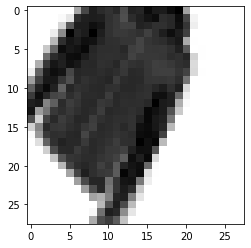

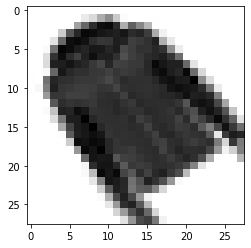

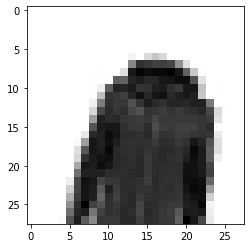

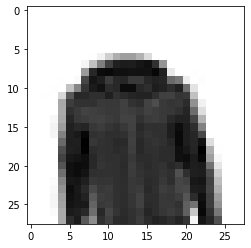

In [0]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]),cmap='binary')
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow(
            train_images, 
            train_labels, 
            batch_size=100)

val_generator = test_datagen.flow(
            val_images, 
            val_labels, 
            batch_size=100)

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [0]:
for data_batch, labels_batch in val_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (100, 28, 28, 1)
labels batch shape: (100,)


In [0]:
steps_per_epoch = len(train_images) /100,
validation_steps = len(val_images) /100

In [0]:
train_rt = TrainRuntimeCallback()
history = model_3c.fit(
      train_generator,
      steps_per_epoch = len(train_images) /100,
      epochs= 20,
      callbacks=[train_rt],
      validation_data= val_generator, 
      validation_steps = len(val_images) /100)

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_3c_aug.h5'
model_path = os.path.join(save_dir, model_name)
model_3c.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 21s 39ms/step - loss: 1.9099 - accuracy: 0.2903 - val_loss: 1.3946 - val_accuracy: 0.4718
Epoch 2/20
550/550 [==============================] - 21s 39ms/step - loss: 1.6235 - accuracy: 0.3982 - val_loss: 1.1780 - val_accuracy: 0.5666
Epoch 3/20
550/550 [==============================] - 22s 39ms/step - loss: 1.4805 - accuracy: 0.4578 - val_loss: 1.0701 - val_accuracy: 0.6216
Epoch 4/20
550/550 [==============================] - 21s 39ms/step - loss: 1.3711 - accuracy: 0.4991 - val_loss: 0.9601 - val_accuracy: 0.6642
Epoch 5/20
550/550 [==============================] - 22s 39ms/step - loss: 1.2962 - accuracy: 0.5251 - val_loss: 0.9290 - val_accuracy: 0.6626
Epoch 6/20
550/550 [==============================] - 22s 40ms/step - loss: 1.2479 - accuracy: 0.5408 - val_loss: 0.9427 - val_accuracy: 0.6534
Epoch 7/20
550/550 [==============================] - 22s 40ms/step - loss: 1.2114 - accuracy: 0.5530 - val_loss: 0.8642 - val_accuracy:

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

436.083312

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_3c.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 3ms/step - loss: 649.2626 - accuracy: 0.1370


In [0]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

1.024631

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,1.069209,0.606036,0.785015,0.7022
16,1.060417,0.609291,0.788598,0.7148
17,1.048424,0.612109,0.813323,0.7034
18,1.035333,0.615309,0.749756,0.7238
19,1.025814,0.621236,0.765337,0.7222


In [0]:
# Pull statistics 
# Pull statistics 
results_df3c = history_df.iloc[-1:].copy()
results_df3c.insert(0,'model','CNN (2 layers aug)') # want the model name to appear first
results_df3c['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df3c['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df3c

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (2 layers aug),1.025814,0.621236,0.765337,0.7222,436.083312,1.024631


In [0]:
# Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = results_df.append(results_df3a,ignore_index=True)
# results_df = results_df.append(results_df3b,ignore_index=True)
# results_df

## Plot the performance 

**Figure 5: Learning curves for Model 3c**

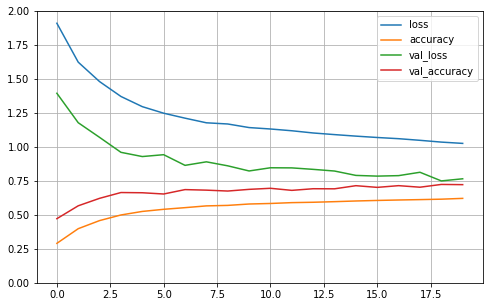

In [0]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_3c aug", tight_layout=False)
plt.show()

## Visualization of intermediate activations
Selecting the "best" model from Experiment 3, we now extract the outputs from 2 selected filters from the 2 max pooling layers and visualize them in a grid as Images. Examining whether the lit up regions correspond to some features in the original images will shed light on how activation works across channels and layers.

In [0]:
# import matplotlib.pyplot as plt
# import tensorflow as tf
tf.compat.v1.disable_eager_execution() # ADDED FOR EXPERIMENTAL PART
# from tensorflow import keras
# keras.__version__

In [0]:
from tensorflow.keras.models import load_model
# Use model 3b
# model = load_model('results/fashion_mnist_model_3b.h5')
# model.summary()  # As a reminder.
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data
from tensorflow.keras.datasets import fashion_mnist

(_,_), (test_images, test_labels) = fashion_mnist.load_data()

In [0]:
# an ankle boot is used as the input image
from tensorflow.keras.preprocessing import image
import numpy as np

img = test_images[0]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

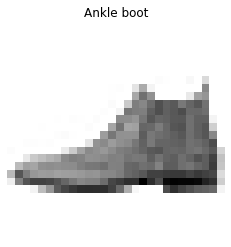

In [0]:
# https://www.tensorflow.org/tutorials/keras/classification
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.imshow(img, cmap="binary")
plt.axis('off')
plt.title(class_names[test_labels[0]], fontsize=12)
plt.show()

In order to extract the feature maps we want to look at, we will create a Keras model that takes batches of images as input, and outputs the activations of all convolution and pooling layers. To do this, we will use the Keras class Model. A Model is instantiated using two arguments: an input tensor (or list of input tensors), and an output tensor (or list of output tensors). The resulting class is a Keras model, just like the Sequential models that you are familiar with, mapping the specified inputs to the specified outputs. What sets the Model class apart is that it allows for models with multiple outputs, unlike Sequential. 

In [0]:
# Extracts the outputs of the all the layers
layer_outputs = [layer.output for layer in model.layers]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
# Examine layer names
layer_names = []
for layer in model.layers[:7]:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

In [0]:
# When fed the image input, this model returns the values of the layer activations in the original model. 
# The model has 1 input and 7 outputs, one output per layer activation. 
activations = activation_model.predict(img_tensor)
len(activations)

7

In [0]:
# For instance, this is the activation of the first convolution layer for our ankle boot image input
first_layer_activation = activations[0]
first_layer_activation.shape

(1, 26, 26, 32)

In [0]:
# It's a 148x148 feature map with 32 channels. Let's try visualizing the 3rd channel: 
third_channel = first_layer_activation[0,:, :,3]
third_channel.shape

(26, 26)

**Figure 6: Channel 3 of Conv2d layer**

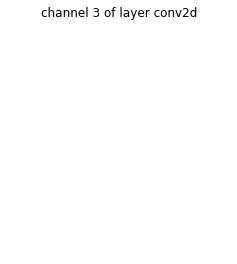

In [0]:
plt.matshow(third_channel, cmap='binary')
plt.axis('off')
plt.title(f"channel 3 of layer {layer_names[0]}", fontsize=12)
plt.show()

**Figure 7: Activations for all the channels in the first convolution layer**

The feature map has shape (1, 26, 26, 32)


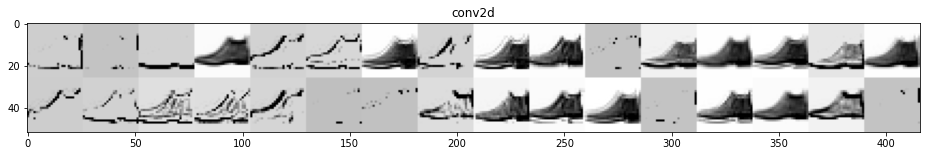

In [0]:
# We display the activations for all the channels in the first convolution layer. 
images_per_row = 16

layer_name, layer_activation = layer_names[0], activations[0]
    
# This is the number of features in the feature map
n_features = layer_activation.shape[-1]

# The feature map has shape (1, size, size, n_features)
size = layer_activation.shape[1]

print(f"The feature map has shape (1, {size}, {size}, {n_features})")

# We will tile the activation channels in this matrix
n_cols = n_features // images_per_row
display_grid = np.zeros((size * n_cols, images_per_row * size))

# We'll tile each filter into this big horizontal grid
for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = layer_activation[0,
                                         :, :,
                                         col * images_per_row + row]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image

# Display the grid
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='binary')

plt.show()

**Figure 8: Activations for all the channels in the first max pooling layer** 

The feature map has shape (1, 13, 13, 32)


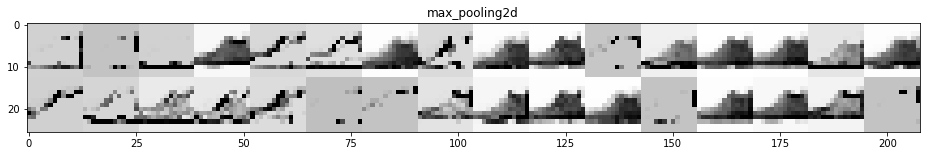

In [0]:
# We display the activations for all the channels in the first max pooling layer. 
images_per_row = 16

layer_name, layer_activation = layer_names[1], activations[1]
    
# This is the number of features in the feature map
n_features = layer_activation.shape[-1]

# The feature map has shape (1, size, size, n_features)
size = layer_activation.shape[1]

print(f"The feature map has shape (1, {size}, {size}, {n_features})")

# We will tile the activation channels in this matrix
n_cols = n_features // images_per_row
display_grid = np.zeros((size * n_cols, images_per_row * size))

# We'll tile each filter into this big horizontal grid
for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = layer_activation[0,
                                         :, :,
                                         col * images_per_row + row]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size,
                     row * size : (row + 1) * size] = channel_image

# Display the grid
scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1],
                    scale * display_grid.shape[0]))
plt.title(layer_name)
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='binary')

plt.show()

We use a loop to display all the channels of all the activations in the convolution and max pooling layers. This code comes from Chapter 5 Section 4 of the Chollet book:

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

**Figure 9: All the channels of all the activations in the convolution and max pooling layers**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


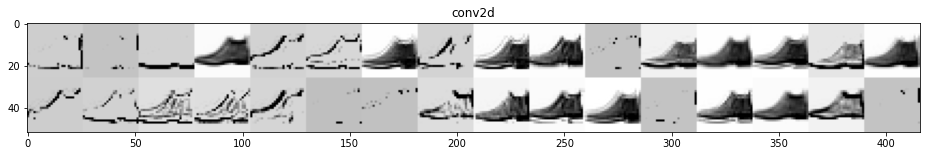

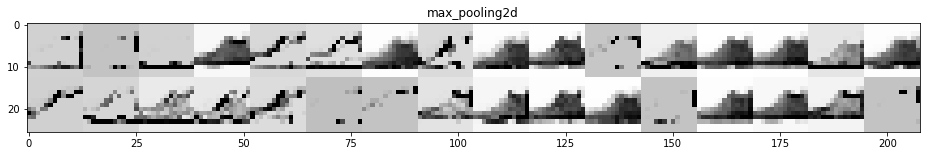

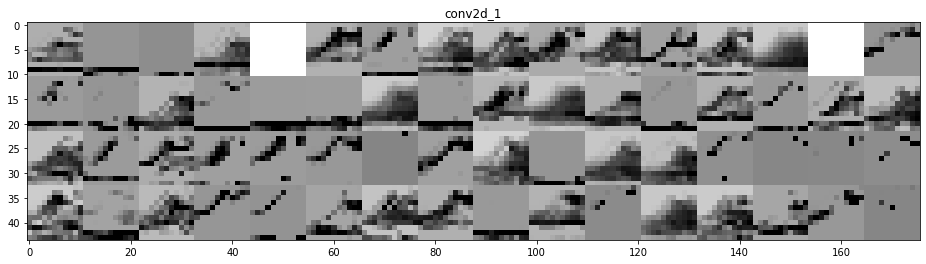

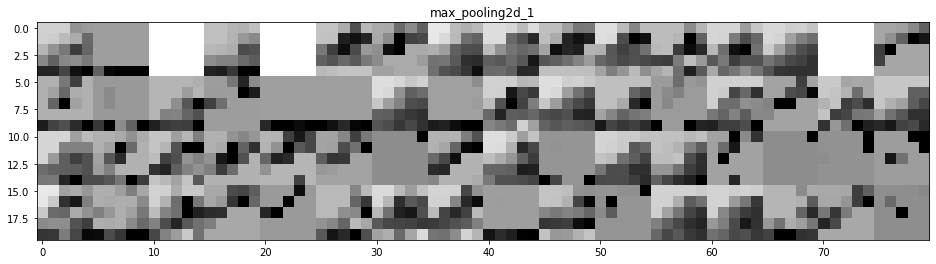

In [0]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    
    if layer_name == 'flatten': 
        break
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='binary')
    
plt.show()

### Additional visualization/experimentation

In [0]:
from tensorflow.keras import backend as K

In [0]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
def generate_pattern(layer_name, filter_index, size=28):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 1)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

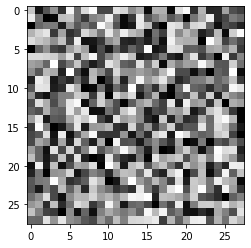

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np


plt.imshow(generate_pattern('conv2d',0).reshape(28,28), cmap="binary")

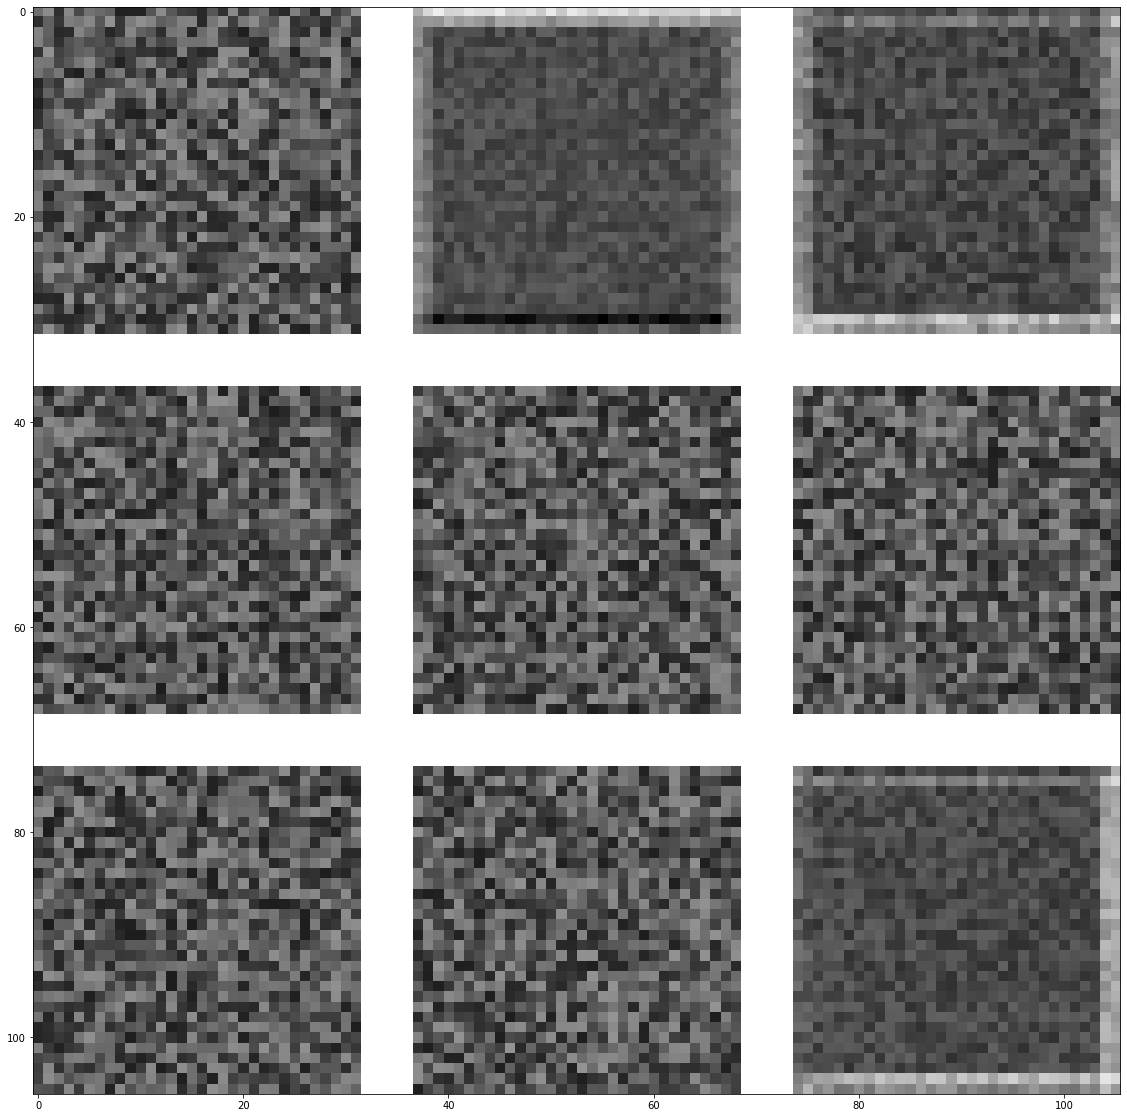

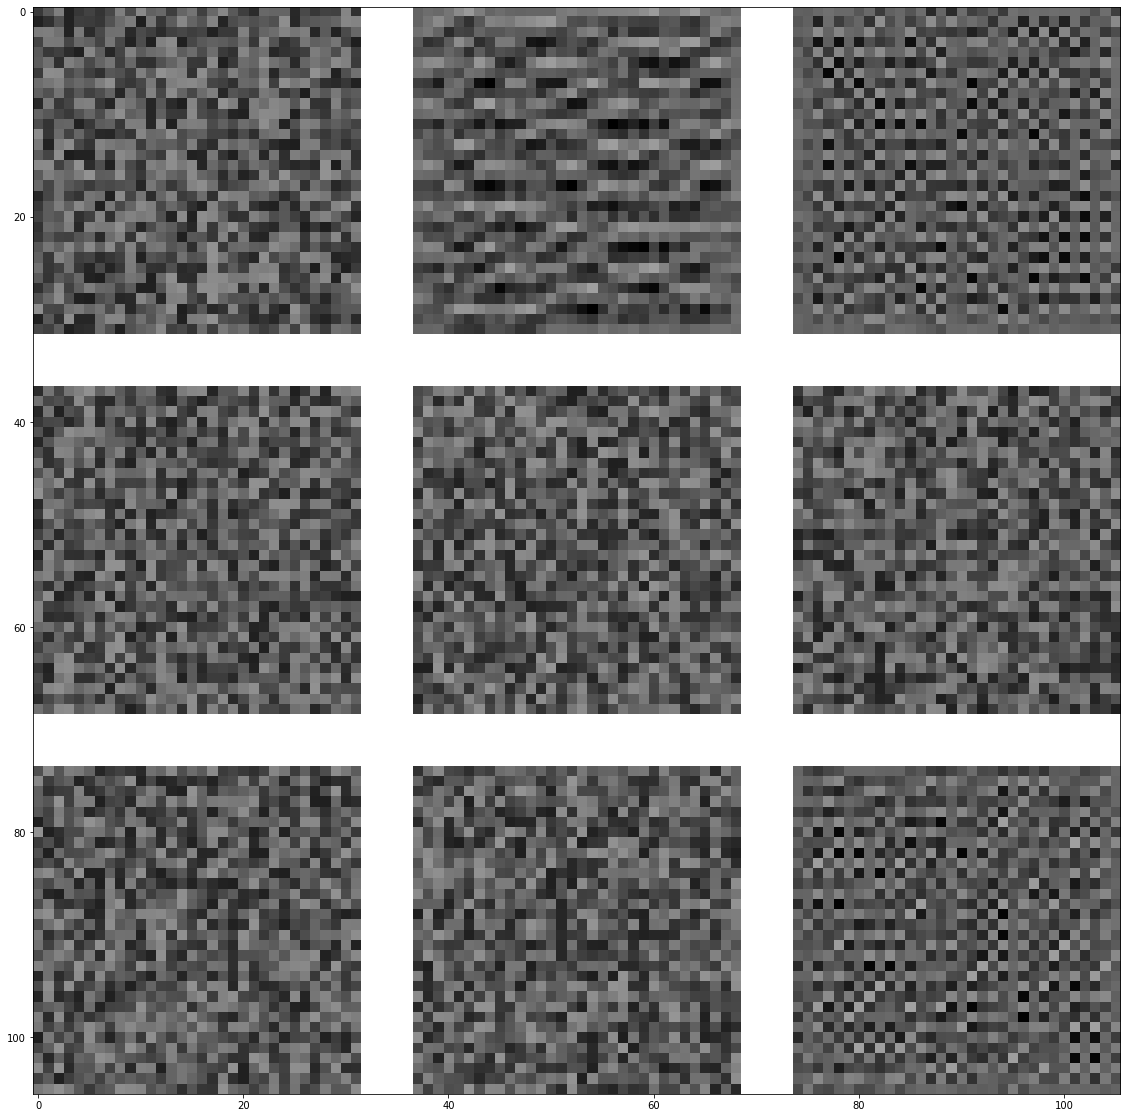

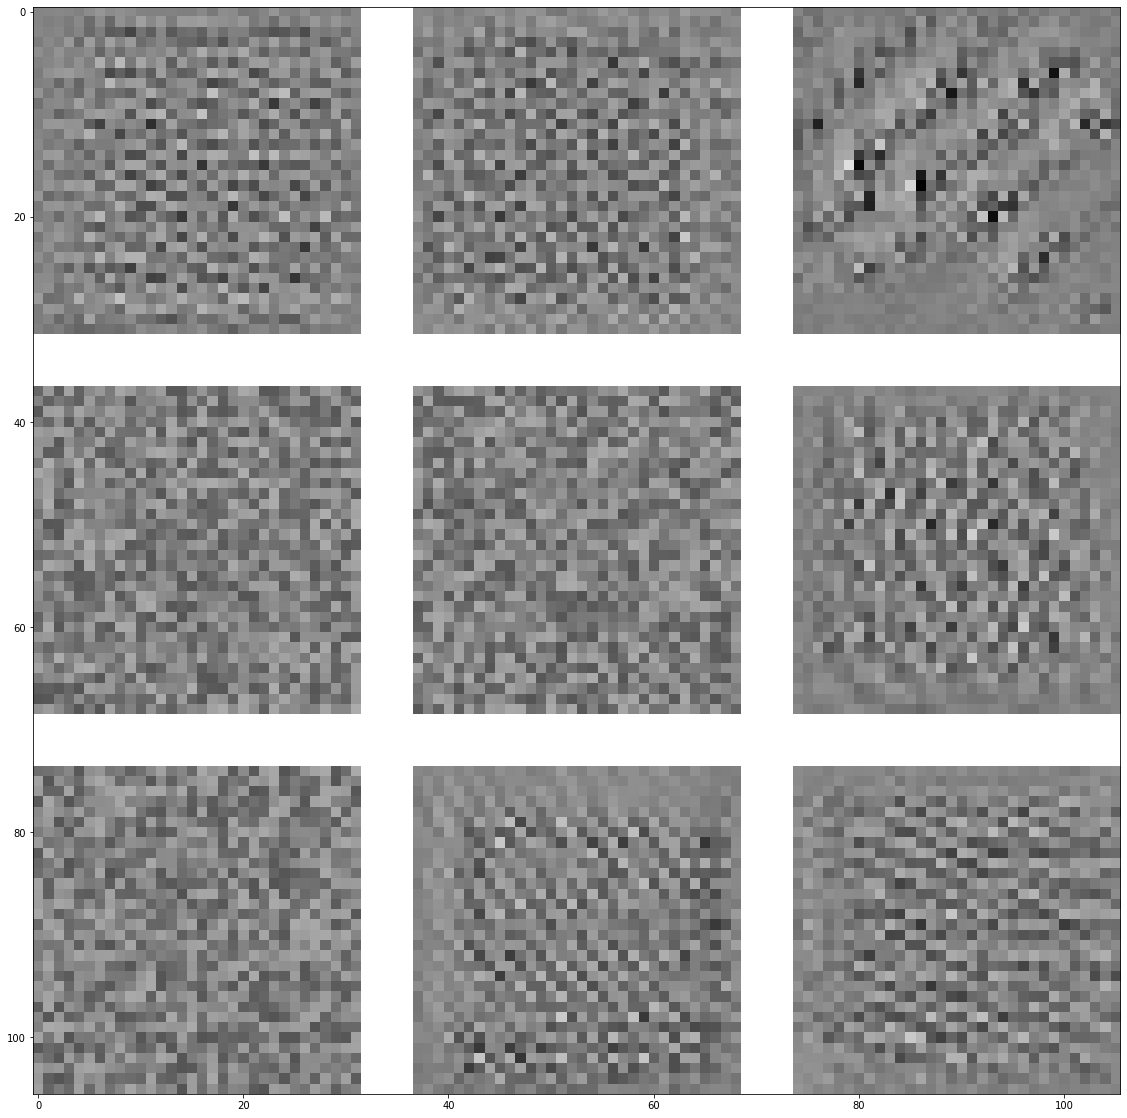

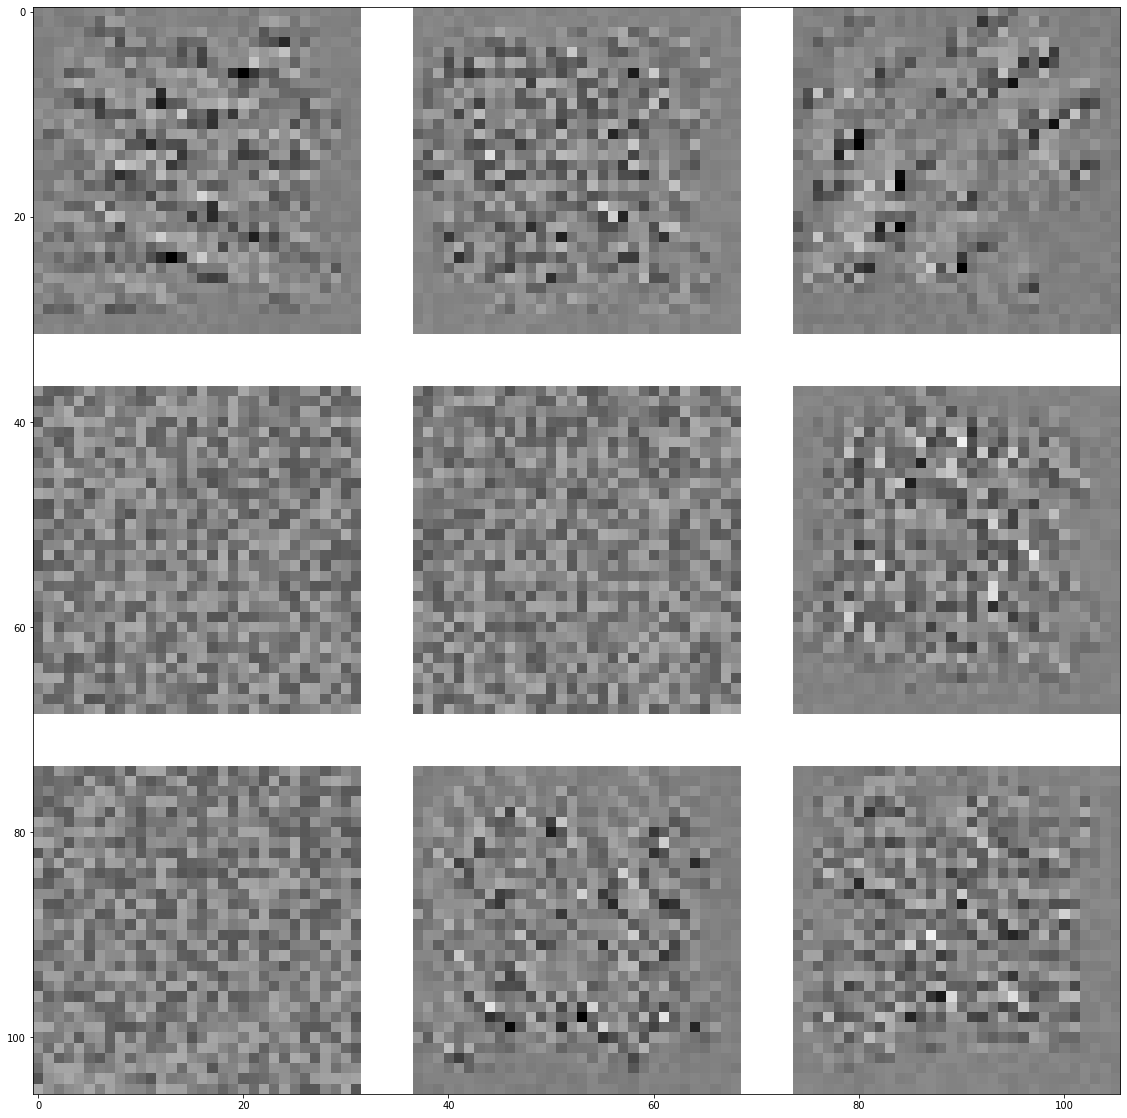

In [0]:
for layer_name in ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1']:
    size = 32
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((3 * size + 2 * margin, 3 * size + 2 * margin, 1))

    for i in range(3):  # iterate over the rows of our results grid
        for j in range(3):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 3)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 3), size=size)
            
            #filter_img = filter_img.reshape(32,32)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.reshape(106,106),cmap="binary")
    plt.show()

# EXPERIMENT 4
We create a `CNN` with 3 convolution/max pooling layers (**no drop out**) to work with our Fashion MNIST dataset. The experiment compares performance using L2 regularization in the convolutional layers. Image augmentation is not employed.

## Model 4a: baseline CNN with 3 layers (no L2 regularization)

In [0]:
model_4a = models.Sequential()
model_4a.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_4a.add(layers.MaxPooling2D((2, 2)))
model_4a.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4a.add(layers.MaxPooling2D((2, 2)))
model_4a.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4a.add(layers.Flatten())
model_4a.add(layers.Dense(64, activation='relu'))
model_4a.add(layers.Dense(10, activation='softmax'))

In [0]:
model_4a.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

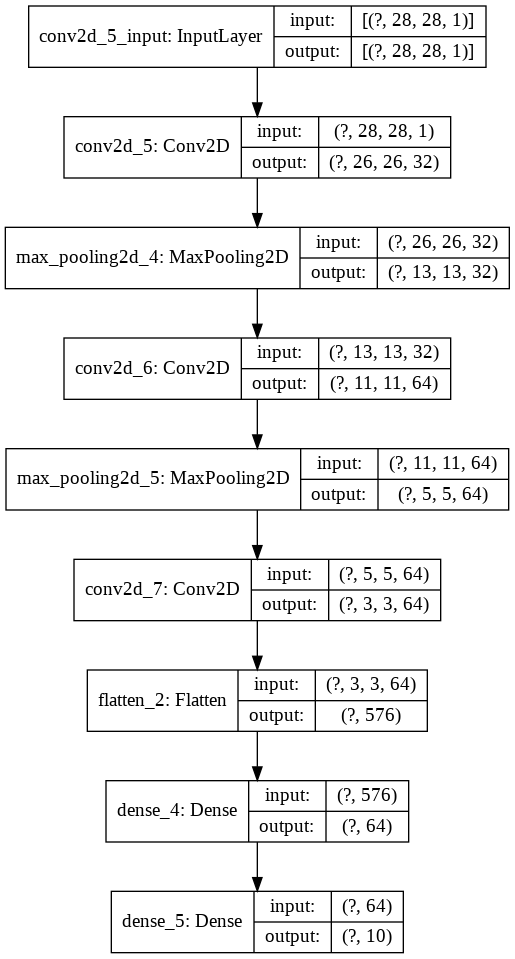

In [0]:
keras.utils.plot_model(model_4a, show_shapes=True)

## Compile the model

In [0]:
model_4a.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [0]:
train_rt = TrainRuntimeCallback()
history = model_4a.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_4a.h5'
model_path = os.path.join(save_dir, model_name)
model_4a.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6044 - accuracy: 0.7810 - val_loss: 0.4046 - val_accuracy: 0.8604
Epoch 2/20
550/550 [==============================] - 2s 4ms/step - loss: 0.3739 - accuracy: 0.8649 - val_loss: 0.3428 - val_accuracy: 0.8778
Epoch 3/20
550/550 [==============================] - 2s 4ms/step - loss: 0.3202 - accuracy: 0.8833 - val_loss: 0.2993 - val_accuracy: 0.8972
Epoch 4/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2876 - accuracy: 0.8943 - val_loss: 0.2804 - val_accuracy: 0.8984
Epoch 5/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2605 - accuracy: 0.9029 - val_loss: 0.2834 - val_accuracy: 0.8992
Epoch 6/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2410 - accuracy: 0.9107 - val_loss: 0.2672 - val_accuracy: 0.9010
Epoch 7/20
550/550 [==============================] - 2s 4ms/step - loss: 0.2263 - accuracy: 0.9165 - val_loss: 0.2556 - val_accuracy: 0.9044
Epoch 

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

44.815734

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_4a.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 3ms/step - loss: 0.3253 - accuracy: 0.9139


In [0]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

1.112644

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.117264,0.957145,0.273387,0.9130
16,0.107623,0.959927,0.279261,0.9146
17,0.099602,0.963036,0.286188,0.9164
18,0.092993,0.964491,0.293478,0.9132
19,0.082464,0.969909,0.314664,0.9150


In [0]:
# Pull statistics 
# Pull statistics 
results_df4a = history_df.iloc[-1:].copy()
results_df4a.insert(0,'model','CNN (3 layers)') # want the model name to appear first
results_df4a['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df4a['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df4a

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (3 layers),0.082464,0.969909,0.314664,0.915,44.815734,1.112644


In [0]:
# Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = results_df.append(results_df3a,ignore_index=True)
# results_df = results_df.append(results_df3b,ignore_index=True)
# results_df

## Plot the performance 

**Figure 10: Learning curves for Model 4a**

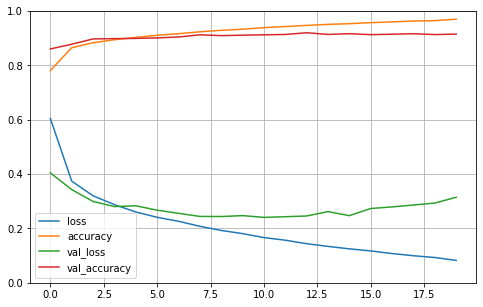

In [0]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_4a", tight_layout=False)
plt.show()

## Model 4b:  CNN with 3 layers + L2 regularization

In [0]:
model_4b = models.Sequential()
model_4b.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01),
                           input_shape=(28, 28, 1)))
model_4b.add(layers.MaxPooling2D((2, 2)))
model_4b.add(layers.Conv2D(64, (3, 3), activation='relu',  
                           kernel_regularizer=regularizers.l2(0.01)))
model_4b.add(layers.MaxPooling2D((2, 2)))
model_4b.add(layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)))
model_4b.add(layers.Flatten())
model_4b.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_4b.add(layers.Dense(10, activation='softmax'))

In [0]:
model_4b.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

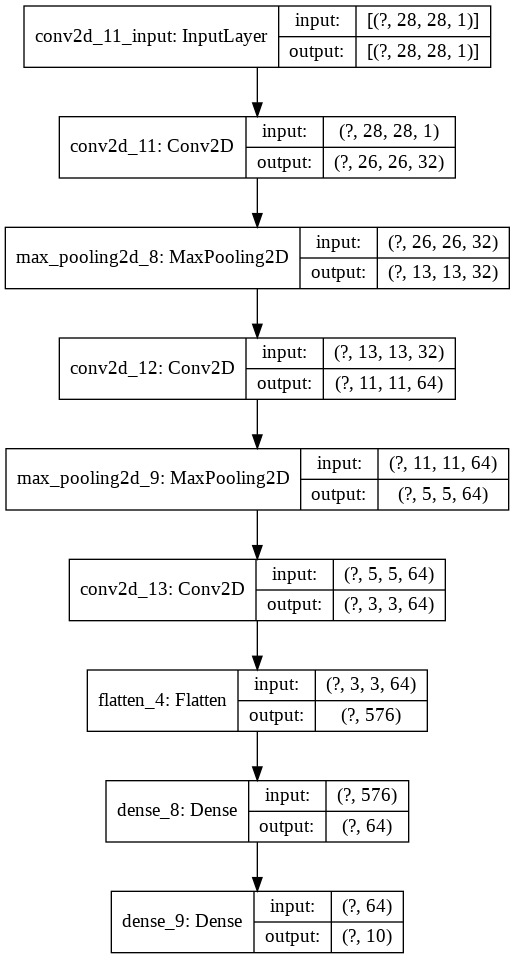

In [0]:
keras.utils.plot_model(model_4b, show_shapes=True)

## Compile the model

In [0]:
model_4b.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## Train the model

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data. We train the model for 20 epochs with batch size 100. Also we pass the method the callback object we create to get the total training time.

In [0]:
train_rt = TrainRuntimeCallback()
history = model_4b.fit(train_images, train_labels, callbacks=[train_rt], epochs=20, batch_size = 100,
                    validation_data=(val_images, val_labels))

# Saving models locally after fitting
save_dir = "results/"
model_name = 'fashion_mnist_model_4b.h5'
model_path = os.path.join(save_dir, model_name)
model_4b.save(model_path)
print('Saved trained model at %s ' % model_path)
print('--------------------------')

Epoch 1/20
550/550 [==============================] - 3s 5ms/step - loss: 1.2457 - accuracy: 0.7219 - val_loss: 0.8538 - val_accuracy: 0.8060
Epoch 2/20
550/550 [==============================] - 2s 4ms/step - loss: 0.8112 - accuracy: 0.7969 - val_loss: 0.7312 - val_accuracy: 0.8238
Epoch 3/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7489 - accuracy: 0.8079 - val_loss: 0.7103 - val_accuracy: 0.8178
Epoch 4/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7193 - accuracy: 0.8145 - val_loss: 0.7220 - val_accuracy: 0.8190
Epoch 5/20
550/550 [==============================] - 2s 4ms/step - loss: 0.7021 - accuracy: 0.8202 - val_loss: 0.6728 - val_accuracy: 0.8372
Epoch 6/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6827 - accuracy: 0.8250 - val_loss: 0.6675 - val_accuracy: 0.8316
Epoch 7/20
550/550 [==============================] - 2s 4ms/step - loss: 0.6731 - accuracy: 0.8274 - val_loss: 0.6372 - val_accuracy: 0.8426
Epoch 

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

48.277778

## Testing the model

Evaluate the model on the test dataset using a callback to get the total test time.

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model_4b.evaluate(test_images, test_labels, callbacks=[test_rt])

313/313 [==============================] - 1s 3ms/step - loss: 0.6101 - accuracy: 0.8428


In [0]:
# Get the test time
test_time = test_rt.process_time
test_time # in seconds

1.097991

## Create a DataFrame for the training and test statistics

We will create a new DataFrame to hold the training/test times and their accuracy and loss values of the current model. We then "unpickle" the DataFrame from the previous notebook and append the new DataFrame to it. 

The resulting DataFrame will hold the statistics for all the models we have worked with so far.

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.604930,0.844036,0.589341,0.8528
16,0.599858,0.846164,0.596906,0.8516
17,0.596931,0.844636,0.612847,0.8454
18,0.592211,0.846836,0.581752,0.8556
19,0.589668,0.846236,0.581835,0.8528


In [0]:
# Pull statistics 
# Pull statistics 
results_df4b = history_df.iloc[-1:].copy()
results_df4b.insert(0,'model','CNN (3 layers L2)') # want the model name to appear first
results_df4b['training time (sec)'] = train_time      # we are okay with training time appearing last
results_df4b['testing time (sec)'] = test_time      # we are okay with training time appearing last
results_df4b

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
19,CNN (3 layers L2),0.589668,0.846236,0.581835,0.8528,48.277778,1.097991


In [0]:
# Combine with previous results
# prev_results_df = pd.read_pickle('results.pkl')
# results_df = results_df.append(results_df3a,ignore_index=True)
# results_df = results_df.append(results_df3b,ignore_index=True)
# results_df

## Plot the performance 

**Figure 11: Learning curves for Model 4b**

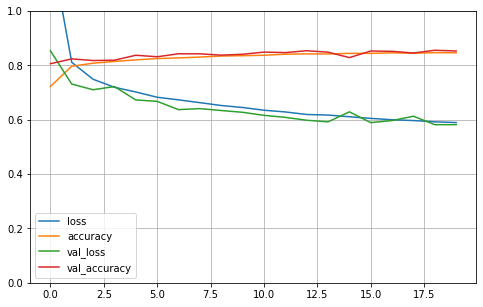

In [0]:
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.savefig("figures/learning_curves_model_4b", tight_layout=False)
plt.show()

# Compile all results into a DataFrame

In [0]:
# # Add the new data to results_df:
# results_df2
# results_df3a
# results_df3b
# results_df3c
# results_df4a
# results_df4b
results_df=results_df.append(results_df2,ignore_index=True)
results_df=results_df.append(results_df3a,ignore_index=True)
results_df=results_df.append(results_df3b,ignore_index=True)
results_df=results_df.append(results_df3c,ignore_index=True)
results_df=results_df.append(results_df4a,ignore_index=True)
results_df=results_df.append(results_df4b,ignore_index=True)
results_df

,model,loss,accuracy,val_loss,val_accuracy,training time (sec),testing time (sec)
0,DNN (2 layers),0.445179,0.845818,0.446092,0.8482,33.456518,0.959970
1,DNN (3 layers),0.393804,0.862691,0.418285,0.8578,33.351694,0.907039
2,CNN (2 layers),0.062694,0.977255,0.342600,0.9102,46.694116,1.092569
3,CNN (2 layers L2),0.520660,0.857909,0.493949,0.8732,43.898222,1.081623
4,CNN (2 layers aug),1.025814,0.621236,0.765337,0.7222,436.083312,1.024631
5,CNN (3 layers),0.082464,0.969909,0.314664,0.9150,44.815734,1.112644
6,CNN (3 layers L2),0.589668,0.846236,0.581835,0.8528,48.277778,1.097991


In [0]:
# Save results
results_df.to_pickle('results/results_table.pkl') # save the DataFrame to use in Part 2